In [198]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from functions import share, to_index
from quantecon import hamilton_filter

import statsmodels.api as sm
from linearmodels.panel.model import PanelOLS
from statsmodels.tsa.api import VAR

### **Credit Booms**

In [123]:
fc = pd.read_csv('./data/processed/agg_firm_credit.csv', index_col=['sector', 'account'])
fc.columns = pd.to_datetime(fc.columns)

fc_total = pd.DataFrame(fc.loc[('nonfin', slice(None)), :].sum().rename('fc'))
fc_total.index = pd.to_datetime(fc_total.index)

fc_total = pd.DataFrame(fc.loc[('nonfin', slice(None)), :].sum().rename('fc'))
fc_total.index = pd.to_datetime(fc_total.index)

gdp = pd.read_csv('./data/processed/gdp.csv', index_col=['Unnamed: 0'])
gdp = gdp.T
gdp.index = pd.to_datetime(gdp.index)

In [124]:
credit_to_gdp = pd.DataFrame(fc_total.fc / gdp.gdp, columns=['total'])
credit_to_gdp = pd.concat([credit_to_gdp, 
                           (fc.loc[('nonfin', 'bonds'), :] / gdp.gdp).rename('bonds'), 
                           (fc.loc[('nonfin', 'loans'), :] / gdp.gdp).rename('loans'),
                           (fc.loc[('nonfin', 'govloans'), :] / gdp.gdp).rename('govloans')], axis=1)

In [125]:
tc = credit_to_gdp.total

cycle, trend = hamilton_filter(tc, h=4) # Apply Hamiltonian filter to total credit-to-gdp to detrend.
credit_cycle = pd.Series(cycle, index=tc.index).dropna()

threshold = credit_cycle.std() # Set the threshold for credit boom
print(credit_cycle[credit_cycle > threshold].index) # Among our period of interest, 2020 is the first year of credit boom.

DatetimeIndex(['1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1985-01-01', '1992-01-01', '1993-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2020-01-01', '2021-01-01', '2022-01-01',
               '2023-01-01'],
              dtype='datetime64[ns]', freq=None)


### **Credit Allocation and Economic Growth**

In [301]:
ifc = pd.read_csv('./data/processed/industry_firm_credit.csv', index_col=['Unnamed: 0'])
ifc.index = pd.to_datetime(ifc.index)

In [302]:
gdp = pd.read_csv('./data/processed/quarterly_gdp.csv', index_col=['Unnamed: 0'])

In [303]:
csgdp = gdp.rolling(window=4).sum()
csgdp = csgdp['2009':]

In [304]:
csgdp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 2009-03-31 to 2023-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ngdp    60 non-null     float64
 1   rgdp    60 non-null     float64
dtypes: float64(2)
memory usage: 1.4+ KB


In [305]:
ifc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2010-03-31 to 2023-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   agr     56 non-null     float64
 1   mmi     56 non-null     float64
 2   cre     56 non-null     float64
 3   taf     56 non-null     float64
 4   tco     56 non-null     float64
 5   etc     56 non-null     float64
dtypes: float64(6)
memory usage: 3.1 KB


In [307]:
y = ifc.div(csgdp.ngdp.loc['2010':].values, axis=0)

In [308]:
y.head()

,agr,mmi,cre,taf,tco,etc
2010-03-31,0.034770,0.172144,0.132745,0.082735,0.025834,0.072590
2010-06-30,0.032838,0.168970,0.126842,0.081878,0.025174,0.071791
2010-09-30,0.031281,0.168756,0.124067,0.081174,0.024766,0.069622
2010-12-31,0.029885,0.162164,0.118449,0.079304,0.024334,0.069460
2011-03-31,0.029216,0.167528,0.116005,0.080293,0.024791,0.070502


In [331]:
tradable = (y.agr + y.mmi) * 100
nontradable = (y.cre + y.taf + y.tco) * 100

tradable = tradable.pct_change(4).shift(-8)
nontradable = nontradable.pct_change(4).shift(-8)

In [332]:
rgdp = csgdp.rgdp.pct_change(4).shift(-4)['2010-06-30':]
rgdp.index = pd.date_range('2010-06-30', '2023-12-31', freq='Q')

In [333]:
data = pd.concat([rgdp, tradable.rename('tradable'), nontradable.rename('nontradable')], axis=1).dropna()

In [336]:
model = VAR(endog=data).fit(maxlags=8, ic='aic')

In [337]:
res = model.summary()

In [338]:
irf = model.irf(8)

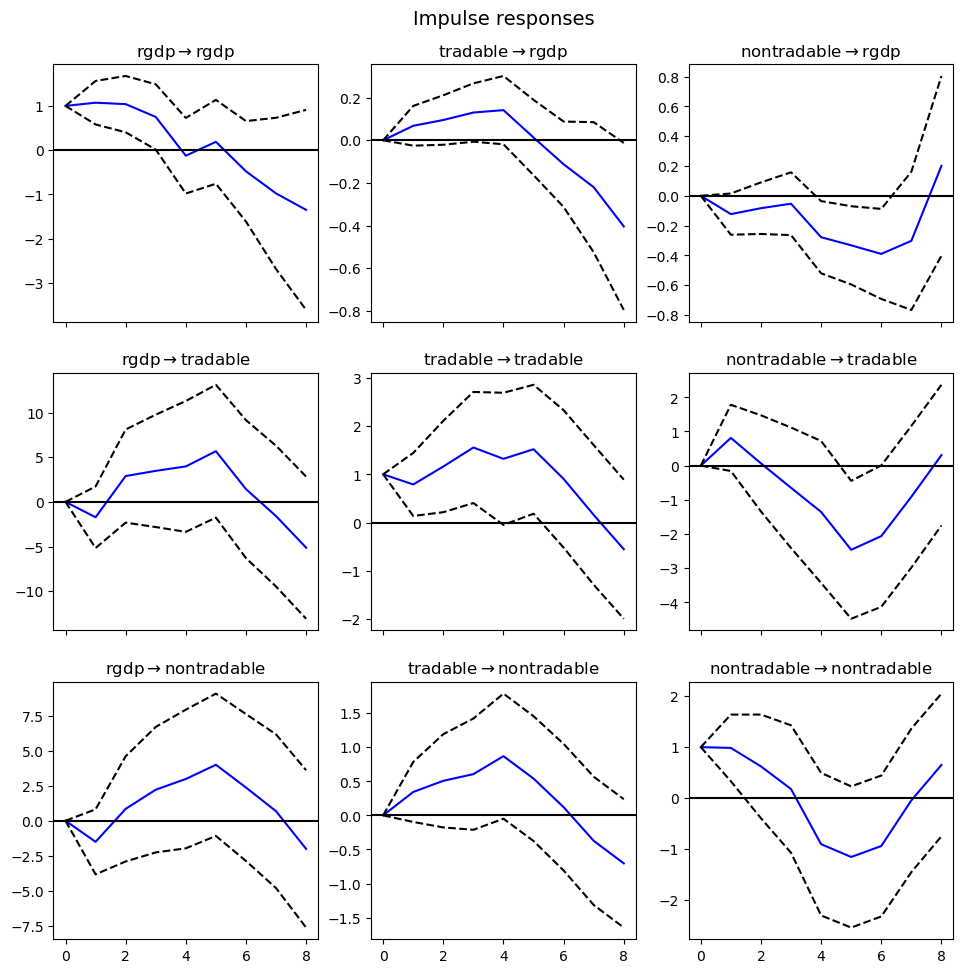

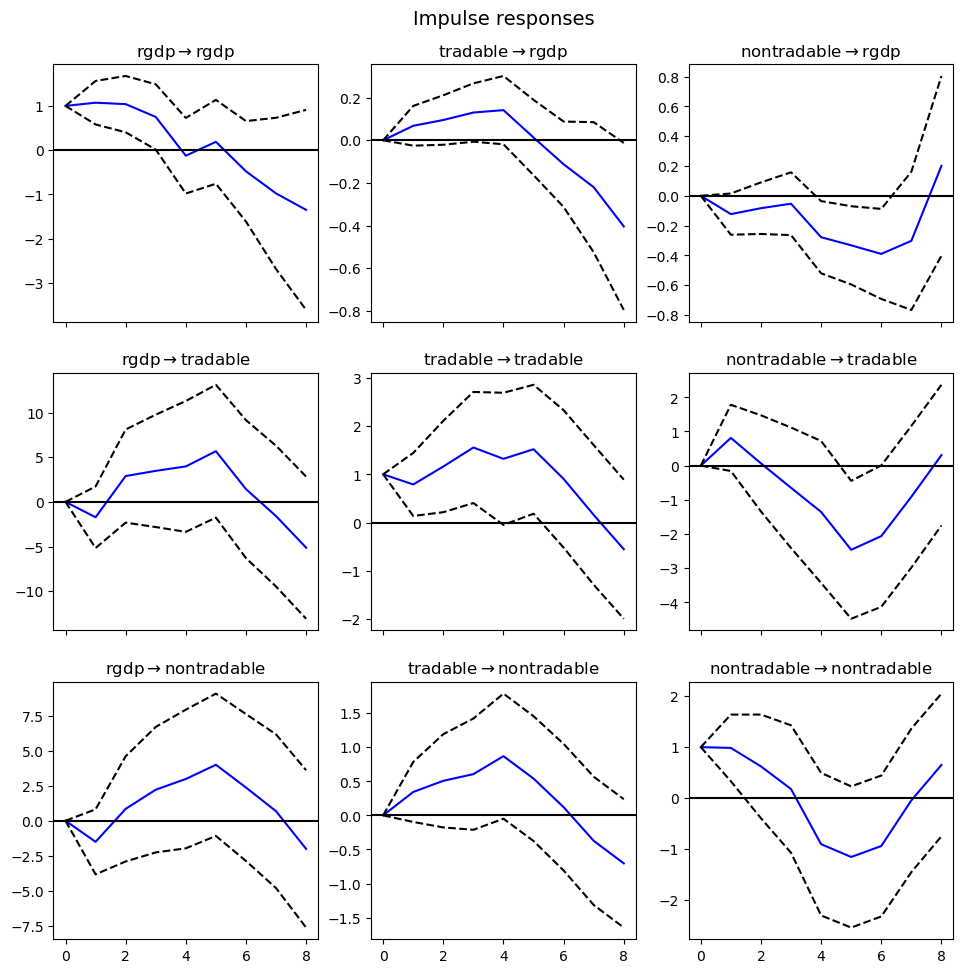

In [343]:
irf.plot(subplot_params={'tight_layout': True})